In [0]:
# Keras 라이브러리 불러오기

# MNIST Dataset을 가져오기 위한 라이브러리
from keras.datasets import mnist

# 딥 러닝 모델을 순차적으로 만들기 위한 라이브러리
from keras.models import Sequential
from keras.models import Model

# Dense : MLP층, Activation : 활성화 함수, Flatten : 2D -> 1D 배열 펼치기
from keras.layers import Activation, Dense, Flatten

# Conv2D : Convolution층, Reshape : 행렬 모양 변환, Conv2DTranspose : Deconvolution층
from keras.layers import Conv2D, Reshape, Conv2DTranspose

import numpy as np # 행렬 계산을 위한 넘파이 라이브러리
import matplotlib.pyplot as plt # 그래프를 그리기 위한 MatPlotLib 라이브러리
from PIL import Image # MatPlotLib 라이브러리와 같이 이미지 처리를 위한 Image 라이브러리

In [0]:
# Dataset 구성

# MNIST Dataset이 저장되어 있는 어딘가에서 MNIST Dataset을 가져옵니다
# _ : 가져온 값을 저장하지 않을 때 사용, DAE는 y값 (Label) 이 필요 없습니다
(x_train, _), (x_test, _) = mnist.load_data() 

# Dataset 전처리

# 픽셀 값을 0~255 범위에서 0~1 범위로 낮춰줍니다 / 오차 값을 적절한 범위에 맞추기 위함
# CNN 입력으로 넣기 위해 784 -> (28, 28, 1) 로 바꾸어줍니다.
# astype('float32') : int(정수)를 float(실수)로 바꾸어줍니다.
x_train = x_train.reshape(60000, 784).reshape((60000, 28, 28, 1)).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).reshape((10000, 28, 28, 1)).astype('float32') / 255.0

print('x_train :', np.shape(x_train))

x_train : (60000, 28, 28, 1)


In [0]:
# 정규 분포로 생성된 노이즈를 원래 이미지에 더하여 노이즈가 낀 데이터를 생성합니다
# 노이즈는 평균 0.5, 표준편차 0.5 의 정규 분포로 생성됩니다

np.random.seed(1337) # 랜덤 값을 만들어주기 위한 seed

# Training Dataset에 대한 노이즈 낀 Dataset 생성
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise

# Test Dataset에 대한 노이즈 낀 Dataset 생성
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

# 노이즈 낀 Dataset의 각 픽셀 값이 1을 넘으면 1로, 0보다 작으면 0으로 해줍니다
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [0]:
input_shape = (28, 28, 1) # MNIST 한 장의 모양
kernel_size = 3 # 커널의 크기

# Encoder 부분 구성
encoder = Sequential(name='Encoder')

encoder.add(Conv2D(filters=32, kernel_size=kernel_size, input_shape=input_shape, strides=2, activation='relu', padding='same'))
encoder.add(Conv2D(filters=64, kernel_size=kernel_size, strides=2, activation='relu', padding='same'))
encoder.add(Flatten()) # 2D -> 1D
encoder.add(Dense(16))
encoder.add(Dense(4, name='latent_vector'))

encoder.summary()

# Decoder 부분 구성
decoder = Sequential(name='decoder')
decoder.add(Dense(16, input_shape=(4,)))
decoder.add(Dense(3136))
decoder.add(Reshape((7, 7, 64))) # 1D -> 3D

decoder.add(Conv2DTranspose(filters=64, kernel_size=kernel_size, strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=32, kernel_size=kernel_size, strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation='sigmoid', padding='same'))

decoder.summary()

# Autoencoder = Encoder + Decoder
autoencoder = Sequential(name='autoencoder')
autoencoder.add(encoder)
autoencoder.add(decoder)
autoencoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_8 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                50192     
_________________________________________________________________
latent_vector (Dense)        (None, 4)                 68        
Total params: 69,076
Trainable params: 69,076
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Sh

In [0]:
# 모델 학습 과정을 설정합니다

# loss는 목적 함수를 의미하며, 회귀 문제이므로 MSE를 사용합니다
# optimizer는 학습 방법을 의미하며, 너무 느린 SGD 대신에 Adam을 사용합니다
# metrics는 학습 도중 화면에 어떤 값을 띄울까를 결정합니다
autoencoder.compile(loss='mse', optimizer='adam')

# Autoencoder 모델을 학습시킵니다

autoencoder.fit(x_train_noisy, x_train, # 입력 : 노이즈 낀 데이터 / 출력 : 기존 데이터
                validation_data=(x_test_noisy, x_test), # Validation을 Test dataset으로 해줍니다 
                epochs=20, # Epoch 수 설정
                batch_size=64 # Mini-batch 크기 설정
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 140us/step - loss: 0.0575 - val_loss: 0.0431
Epoch 2/20
60000/60000 [==============================] - 7s 124us/step - loss: 0.0403 - val_loss: 0.0386
Epoch 3/20
60000/60000 [==============================] - 7s 124us/step - loss: 0.0378 - val_loss: 0.0371
Epoch 4/20
60000/60000 [==============================] - 7s 123us/step - loss: 0.0368 - val_loss: 0.0366
Epoch 5/20
60000/60000 [==============================] - 7s 123us/step - loss: 0.0362 - val_loss: 0.0361
Epoch 6/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.0358 - val_loss: 0.0357
Epoch 7/20
60000/60000 [==============================] - 7s 124us/step - loss: 0.0355 - val_loss: 0.0359
Epoch 8/20
60000/60000 [==============================] - 7s 123us/step - loss: 0.0353 - val_loss: 0.0355
Epoch 9/20
60000/60000 [==============================] - 7s 122us/step - loss: 0.0350 - val_loss: 0.0

(900, 28, 28, 1)
(30, 30, 28, 28)
(300, 3, 28, 28)
(30, 30, 28, 28)
(840, 840)


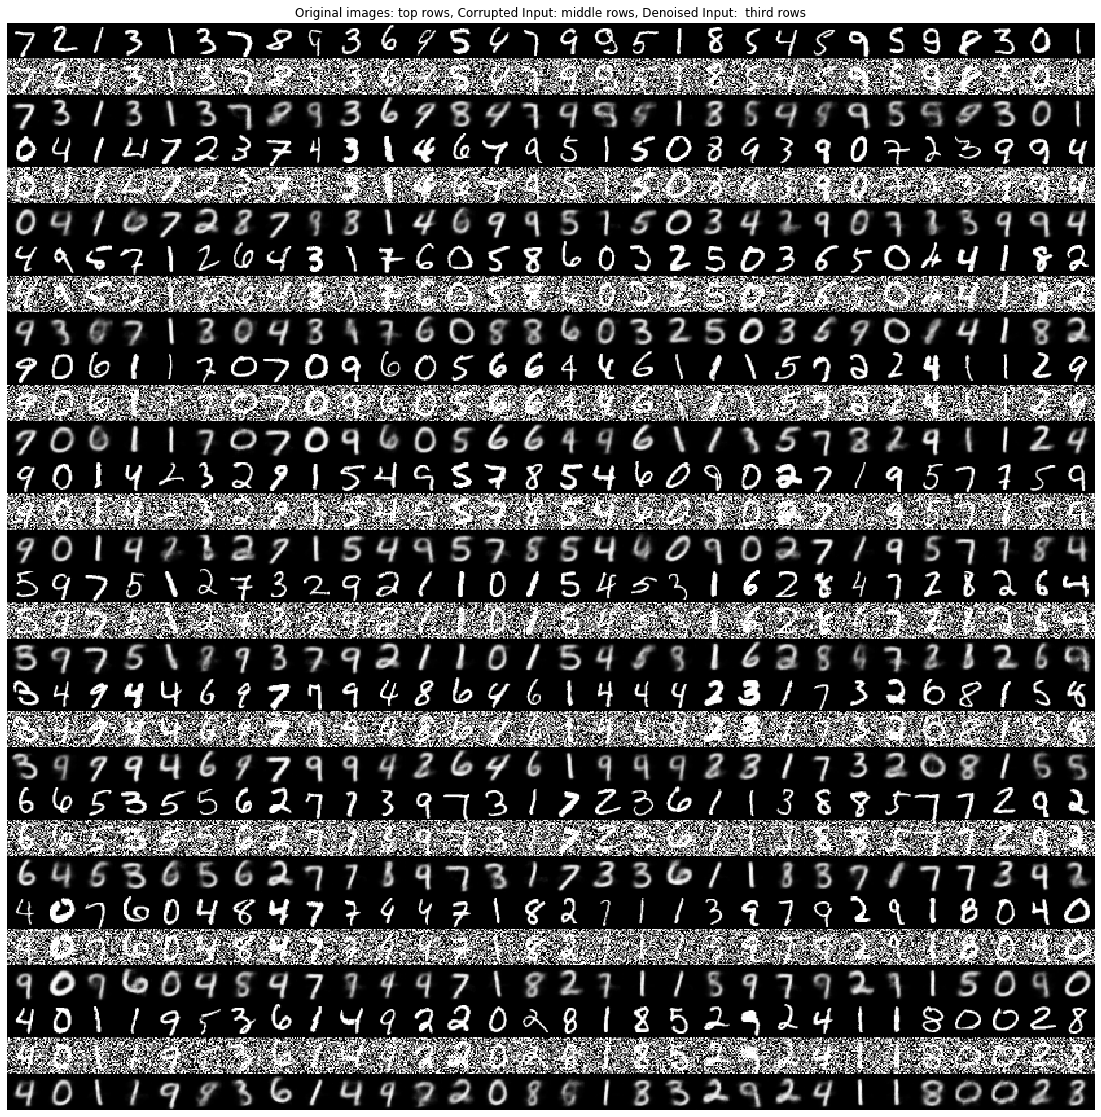

In [0]:
# 실제로 사용해봅시다

# 노이즈 낀 데이터로부터 출력을 받습니다
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 8 corrupted and denoised images
rows, cols = 10, 30
num = rows * cols

# 원본 / 노이즈 추가 / 모델 출력 300장씩 이어붙이기 (900 * 784)
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
print(np.shape(imgs))

# 784 -> 28 * 28 / 900 -> 30 * 30 (30 * 30 * 28 * 28)
imgs = imgs.reshape((rows * 3, cols, 28, 28))
print(np.shape(imgs))

# 30 * 30 -> 300 * 3
# split : axis (0, 1, 2, ...)에 따라 rows(10)개로 나눔 (30 * 10 * 3 * 28 * 28)
# vstack : 맨 앞 차원으로 이어붙힘 (300 * 3 * 28 * 28)
# => 원본 / 노이즈 / 출력을 한줄씩 번갈아 나오게 한다
imgs = np.vstack(np.split(imgs, rows, axis=1))
print(np.shape(imgs))

# (300 * 3 * 28 * 28) -> (30 * 30 * 28 * 28)
imgs = imgs.reshape((rows * 3, -1, 28, 28))
print(np.shape(imgs))

# 이미지 출력을 위해 차원수를 2로 줄여준다
# (30 * 30 * 28 * 28) -> (840, 840)
imgs = np.vstack([np.hstack(i) for i in imgs])
print(np.shape(imgs))

# 0 ~ 1 => 0 ~ 255 / 실수 => 정수
imgs = (imgs * 255).astype(np.uint8)

plt.rcParams["figure.figsize"] = (20,20) # 출력할 이미지 크기 설정
plt.figure()
plt.axis('off') # 축을 안보이게 한다

# 출력 된 이미지 제목 설정, 이미지 위에 나타난다
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')

# 이미지를 흑백(cmap='gray')으로 출력한다
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show() # 이미지 출력

In [0]:
# 본인의 구글 드라이브 → 지금 실행중인 코드

# google.colab.drive : 구글 드라이브에서 파일을 가져오기 위한 코드를 담고 있다.
from google.colab import drive

# 본인의 구글 드라이브를 '/gdrive' 라는 경로로 하여 쓸 수 있다.
drive.mount('/gdrive', force_remount=True)

In [0]:
# 모델은 h5 파일 형태로 저장됩니다
autoencoder.save('/gdrive/My Drive/MNIST_CNN_DAE.h5')

# 모델을 불러오기 위해 지워줍니다
del autoencoder

# 저장되어 있는 모델을 불러오기 위한 load_model 함수
from keras.models import load_model

# 'model' 에 해당 모델을 불러옵니다
model = load_model('/gdrive/My Drive/MNIST_CNN_DAE.h5')